In [3]:
import numpy as np
import os
import pandas as pd
import scipy.interpolate
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule


from matplotlib import pyplot as plt
%matplotlib inline

# Define constants.
n_eval_trials = 1
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_thresholds = 221
n_trial_groups = int(np.floor(10 / n_eval_trials))
n_trials = n_trial_groups * n_eval_trials


# Initialize dicts.
report = {}


model_names = [
    "icassp-convnet",
    "pcen-convnet",
    "pcen-convnet_aug-all-but-noise",
    "pcen-convnet_aug-all",
    "pcen-add-convnet_aug-none",
    "pcen-add-convnet_aug-all-but-noise",
    "pcen-add-convnet_aug-all",
    "pcen-addntt-convnet_aug-all-but-noise",
    "pcen-ntt-convnet_aug-all-but-noise",
    "icassp-convnet_aug-all",
    "icassp-convnet_aug-all-but-noise",
]

# Loop over augmentations.
for model_name in model_names:
    if model_name == "pcen-ntt-convnet_aug-all-but-noise" or "icassp-convnet_aug-all-but-noise":
        model_suffix = "-nomindist" 
    else:
        model_suffix = ""

    # Initialize dictionaries
    aug_report = {
        "test-CV-AUPRC": {},
        "test-CV-F": {},
        "val-AUPRC": {},
        "val-F": {},
    }

    ###############################   VALIDATION   #################################
    val_precisions = np.zeros((n_units, n_trials))
    val_recalls = np.zeros((n_units, n_trials))
    val_f1_scores = np.zeros((n_units, n_trials))
    val_auprcs = np.zeros((n_units, n_trials))
    val_thresholds = np.zeros((n_units, n_trials))
    val_threshold_ids = np.zeros((n_units, n_trials))


    thresholds = 1.0 - np.concatenate((
        np.logspace(-9, -2, 141), np.delete(np.logspace(-2, 0, 81), 0)
    ))
    n_thresholds = len(thresholds)


    # Define model directory
    model_dir = os.path.join(models_dir, model_name)


    # Loop over test units.
    for test_unit_id in range(n_units):

        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)

        # Retrieve fold such that unit_str is in the test set.
        folds = localmodule.fold_units()
        fold = [f for f in folds if test_unit_str in f[0]][0]
        test_units = fold[0]
        validation_units = fold[2]

        # Loop over trials.
        for trial_id in range(n_trials):

            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            break_switch = False

            # Loop over validation units.
            for predict_unit_str in validation_units:
                val_metrics_name = "_".join([
                    dataset_name,
                    model_name + model_suffix,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + predict_unit_str,
                    "full-audio-metrics.csv"
                ])
                val_metrics_path = os.path.join(trial_dir, val_metrics_name)
                val_tp = np.zeros((n_thresholds,))
                val_fp = np.zeros((n_thresholds,))
                val_fn = np.zeros((n_thresholds,))
                try:
                    val_metrics_df = pd.read_csv(val_metrics_path)
                    val_tp = val_tp + np.array(val_metrics_df["True positives"])
                    val_fp = val_fp + np.array(val_metrics_df["False positives"])
                    val_fn = val_fn + np.array(val_metrics_df["False negatives"])
                except:
                    break_switch = True
                    break

            if break_switch:
                val_auprc = 0.0
                val_p = np.zeros((n_thresholds,))
                val_r = np.zeros((n_thresholds,))
                val_f = np.zeros((n_thresholds,))
                val_threshold_id = 0
                val_auprc = 0.0
            else:
                val_p = val_tp / (np.finfo(float).eps + val_tp + val_fp)
                val_r = val_tp / (np.finfo(float).eps + val_tp + val_fn)
                val_f = 2*val_p*val_r / (np.finfo(float).eps+(val_p+val_r))
                val_threshold_id = np.argmax(val_f)
                val_p_ = np.array([1.0] + list(val_p) + [0.0])
                val_r_ = np.array([0.0] + list(val_r) + [1.0])
                val_auprc = sklearn.metrics.auc(val_r_, val_p_, reorder=True)

            val_precisions[test_unit_id, trial_id] = val_p[val_threshold_id]
            val_recalls[test_unit_id, trial_id] = val_r[val_threshold_id]
            val_f1_scores[test_unit_id, trial_id] = val_f[val_threshold_id]
            val_thresholds[test_unit_id, trial_id] = thresholds[val_threshold_id]
            val_threshold_ids[test_unit_id, trial_id] = val_threshold_id
            val_auprcs[test_unit_id, trial_id] = val_auprc


    val_F_tensor = np.reshape(val_f1_scores, (6, n_eval_trials, n_trial_groups))
    val_F_trials = np.zeros((6, n_eval_trials))
    val_F_precisions = np.zeros((6, n_eval_trials))
    val_F_recalls = np.zeros((6, n_eval_trials))
    val_F_f1_scores = np.zeros((6, n_eval_trials))
    val_F_thresholds = np.zeros((6, n_eval_trials))
    val_F_threshold_ids = np.zeros((6, n_eval_trials))
    val_F_auprcs = np.zeros((6, n_eval_trials))


    val_AUPRC_tensor = np.reshape(val_auprcs, (6, n_eval_trials, n_trial_groups))
    val_AUPRC_trials = np.zeros((6, n_eval_trials))
    val_AUPRC_precisions = np.zeros((6, n_eval_trials))
    val_AUPRC_recalls = np.zeros((6, n_eval_trials))
    val_AUPRC_f1_scores = np.zeros((6, n_eval_trials))
    val_AUPRC_thresholds = np.zeros((6, n_eval_trials))
    val_AUPRC_threshold_ids = np.zeros((6, n_eval_trials))
    val_AUPRC_auprcs = np.zeros((6, n_eval_trials))


    # Select best n INDEPENDENT trials out of 10.
    # We proceed by groups to guarantee statistical independence.
    # Loop over test units.
    for test_unit_id in range(6):

        # Loop over trials.
        for eval_trial_id in range(n_eval_trials):

            best_F_column_id = np.argmax(
                val_F_tensor[test_unit_id, eval_trial_id, :])
            trial_F_id = n_trial_groups * eval_trial_id + best_F_column_id
            
            val_F_precisions[test_unit_id, eval_trial_id] =\
                val_precisions[test_unit_id, trial_F_id]
            val_F_recalls[test_unit_id, eval_trial_id] =\
                val_recalls[test_unit_id, trial_F_id]
            val_F_f1_scores[test_unit_id, eval_trial_id] =\
                val_f1_scores[test_unit_id, trial_F_id]
            val_F_trials[test_unit_id, eval_trial_id] =\
                trial_F_id
            val_F_thresholds[test_unit_id, eval_trial_id] =\
                val_thresholds[test_unit_id, trial_F_id]
            val_F_threshold_ids[test_unit_id, eval_trial_id] =\
                val_threshold_ids[test_unit_id, trial_F_id]
            val_F_auprcs[test_unit_id, eval_trial_id] =\
                val_auprcs[test_unit_id, trial_F_id]

            best_AUPRC_column_id = np.argmax(
                val_AUPRC_tensor[test_unit_id, eval_trial_id, :])
            trial_AUPRC_id = n_trial_groups * eval_trial_id + best_AUPRC_column_id
            
            val_AUPRC_precisions[test_unit_id, eval_trial_id] =\
                val_precisions[test_unit_id, trial_AUPRC_id]
            val_AUPRC_recalls[test_unit_id, eval_trial_id] =\
                val_recalls[test_unit_id, trial_AUPRC_id]
            val_AUPRC_f1_scores[test_unit_id, eval_trial_id] =\
                val_f1_scores[test_unit_id, trial_AUPRC_id]
            val_AUPRC_trials[test_unit_id, eval_trial_id] =\
                trial_AUPRC_id
            val_AUPRC_thresholds[test_unit_id, eval_trial_id] =\
                val_thresholds[test_unit_id, trial_AUPRC_id]
            val_AUPRC_threshold_ids[test_unit_id, eval_trial_id] =\
                val_threshold_ids[test_unit_id, trial_AUPRC_id]
            val_AUPRC_auprcs[test_unit_id, eval_trial_id] =\
                val_auprcs[test_unit_id, trial_AUPRC_id]


    aug_report["val-F"] = {
        "P": val_F_precisions,
        "R": val_F_recalls,
        "F": val_F_f1_scores,
        "trials": val_F_trials,
        "thresholds": val_F_thresholds,
        "threshold_ids": val_F_threshold_ids,
        "AUPRC": val_F_auprcs
    }


    aug_report["val-AUPRC"] = {
        "P": val_AUPRC_precisions,
        "R": val_AUPRC_recalls,
        "F": val_AUPRC_f1_scores,
        "trials": val_AUPRC_trials,
        "thresholds": val_AUPRC_thresholds,
        "threshold_ids": val_AUPRC_threshold_ids,
        "AUPRC": val_AUPRC_auprcs
    }


    ###############################   TEST   #################################

    for mode in ["F", "AUPRC"]:
        val_mode = "val-" + mode
        test_mode = "test-CV-" + mode

        aug_report[test_mode] = {
            "CV-P": np.zeros((n_eval_trials,)),
            "CV-R": np.zeros((n_eval_trials,)),
            "CV-F": np.zeros((n_eval_trials,)),
            "CV-AUPRC": np.zeros((n_eval_trials,)),
            "P": np.zeros((n_thresholds, n_eval_trials)),
            "R": np.zeros((n_thresholds, n_eval_trials)),
            "F": np.zeros((n_thresholds, n_eval_trials))
        }

        # Loop over trials.
        for eval_trial_id in range(n_eval_trials):
            break_switch = False

            test_tp = np.zeros((n_thresholds,))
            test_fp = np.zeros((n_thresholds,))
            test_fn = np.zeros((n_thresholds,))

            for test_unit_id in range(n_units):

                test_unit_str = units[test_unit_id]
                test_unit_dir = os.path.join(model_dir, test_unit_str)

                trial_id = int(aug_report[
                    val_mode]["trials"][test_unit_id, eval_trial_id])
                trial_str = "trial-" + str(trial_id)
                trial_dir = os.path.join(test_unit_dir, trial_str)

                # Load test predictions.
                test_metrics_name = "_".join([
                    dataset_name,
                    model_name + model_suffix,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + test_unit_str,
                    "full-audio-metrics.csv"
                ])
                test_metrics_path = os.path.join(trial_dir, test_metrics_name)
                try:
                    test_metrics_df = pd.read_csv(test_metrics_path)
                    test_tp = test_tp + np.array(test_metrics_df["True positives"])
                    test_fp = test_fp + np.array(test_metrics_df["False positives"])
                    test_fn = test_fn + np.array(test_metrics_df["False negatives"])
                except:
                    break_switch = True


            if break_switch:
                print(model_name + model_suffix + " break switch")
                test_auprc = 0.0
                test_p = np.zeros((n_thresholds,))
                test_r = np.zeros((n_thresholds,))
                test_f = np.zeros((n_thresholds,))
                test_threshold = 1.0
                test_threshold_id = 0
                test_auprc = 0.0
            else:
                test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
                test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
                test_f = 2*test_p*test_r / (np.finfo(float).eps+(test_p+test_r))
                test_threshold = aug_report[
                    val_mode]["thresholds"][test_unit_id, eval_trial_id]
                test_threshold_id = int(aug_report[
                    val_mode]["threshold_ids"][test_unit_id, eval_trial_id])
                test_p_ = np.array([1.0] + list(test_p) + [0.0])
                test_r_ = np.array([0.0] + list(test_r) + [1.0])
                test_auprc = sklearn.metrics.auc(test_r_, test_p_, reorder=True)



            aug_report[test_mode]["CV-P"][eval_trial_id] = test_p[test_threshold_id]
            aug_report[test_mode]["CV-R"][eval_trial_id] = test_r[test_threshold_id]
            aug_report[test_mode]["CV-F"][eval_trial_id] = test_f[test_threshold_id]
            aug_report[test_mode]["CV-AUPRC"][eval_trial_id] = test_auprc


            aug_report[test_mode]["P"][:, eval_trial_id] = test_p
            aug_report[test_mode]["R"][:, eval_trial_id] = test_r
            aug_report[test_mode]["F"][:, eval_trial_id] = test_f
            

        all_test_recalls = np.array(list(np.sort(np.ravel(aug_report[test_mode]["R"]))))
        interpolated_precisions = np.zeros((2 + len(all_test_recalls), n_eval_trials))

        for eval_trial_id in range(n_eval_trials):
            precision_interpolator = scipy.interpolate.interp1d(
                np.array([0.0] + list(aug_report[test_mode]["R"][:, eval_trial_id]) + [1.0]),
                np.array([1.0] + list(aug_report[test_mode]["P"][:, eval_trial_id]) + [0.0]))
            interpolated_precisions[:, eval_trial_id] =\
                np.array([1.0] + list(precision_interpolator(all_test_recalls)) + [0.0])

        interpolated_recalls = np.array([0.0] + list(all_test_recalls) + [1.0])
        aug_report[test_mode]["interpolated_P"] = np.sort(interpolated_precisions, axis=1)
        aug_report[test_mode]["interpolated_R"] = interpolated_recalls
        aug_report[test_mode]["interpolated_F"] =\
            (2*aug_report[test_mode]["interpolated_P"]*aug_report[test_mode]["interpolated_R"][:, np.newaxis]) /\
            (np.finfo(float).eps+aug_report[test_mode]["interpolated_P"]+aug_report[test_mode]["interpolated_R"][:, np.newaxis])
            

    report[model_name] = aug_report


/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

pcen-add-convnet_aug-none-nomindist break switch
pcen-add-convnet_aug-none-nomindist break switch


/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/v

/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)
/home/vl1019/miniconda3/envs/bvfs/lib/python3.5/site-packages/sklearn/metrics/ranking.py:104: DeprecationWarning: The 'reorder' parameter has been deprecated in version 0.20 and will be removed in 0.22. It is recommended not to set 'reorder' and ensure that x is monotonic increasing or monotonic decreasing.
  DeprecationWarning)


In [4]:
{k: report[k]["test-CV-F"]["CV-AUPRC"] for k in list(report.keys())}

{'icassp-convnet': array([0.50264758]),
 'icassp-convnet_aug-all': array([0.60713829]),
 'icassp-convnet_aug-all-but-noise': array([0.59711323]),
 'pcen-add-convnet_aug-all': array([0.72051278]),
 'pcen-add-convnet_aug-all-but-noise': array([0.76403571]),
 'pcen-add-convnet_aug-none': array([0.]),
 'pcen-addntt-convnet_aug-all-but-noise': array([0.63246539]),
 'pcen-convnet': array([0.64480211]),
 'pcen-convnet_aug-all': array([0.65864213]),
 'pcen-convnet_aug-all-but-noise': array([0.37680531]),
 'pcen-ntt-convnet_aug-all-but-noise': array([0.69108073])}

In [20]:
# OLD BIRD

import numpy as np
import os
import pandas as pd
import sys
sys.path.append("../src")
import localmodule

dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
models_dir = localmodule.get_models_dir()
model_name = "oldbird"
model_dir = os.path.join(models_dir, model_name)
units = localmodule.get_units()
tolerance_ms = 500
tol_str = "tol-" + str(tolerance_ms)
prefix = "_".join([dataset_name, "oldbird_merged_clip-suppressor"])
n_thresholds = 100

unit_relevant = []
unit_selected, unit_tp = [], []

tp_matrix = np.zeros((n_thresholds, n_units))
fp_matrix = np.zeros((n_thresholds, n_units))
fn_matrix = np.zeros((n_thresholds, n_units))

for unit_id, unit_str in enumerate(units):
    unit_dir = os.path.join(model_dir, unit_str)
    metrics_name = "_".join([prefix, unit_str, tol_str, "metrics"])
    metrics_path = os.path.join(unit_dir, metrics_name + ".csv")
    df = pd.read_csv(metrics_path)
    true_positives = np.array(df["True positives"])
    tp_matrix[:, unit_id] = true_positives
    false_positives = np.array(df["False positives"])
    fp_matrix[:, unit_id] = false_positives
    false_negatives = np.array(df["False negatives"])
    fn_matrix[:, unit_id] = false_negatives
    
    
oldbird_tp = np.sum(tp_matrix, axis=1)
oldbird_fp = np.sum(fp_matrix, axis=1)
oldbird_fn = np.sum(fn_matrix, axis=1)

eps = np.finfo(float).eps
oldbird_precisions = oldbird_tp / (eps+oldbird_tp+oldbird_fp)
oldbird_recalls = oldbird_tp / (eps+oldbird_tp+oldbird_fn)

sorting_indices = np.argsort(oldbird_recalls)
oldbird_precisions = oldbird_precisions[sorting_indices]
oldbird_recalls = oldbird_recalls[sorting_indices]

oldbird_f1_scores = 2*oldbird_precisions*oldbird_recalls / (eps+oldbird_precisions+oldbird_recalls)

report["old-bird"] = {}
report["old-bird"]["test-CV-F"] = {
    "interpolated_P": np.array([1] + list(oldbird_precisions) + [0]),
    "interpolated_R": np.array([0] + list(oldbird_recalls) + [1]),
    "interpolated_F": np.array([0] + list(oldbird_f1_scores) + [0])
}

In [92]:
# SKM

tps, fps, fns = [], [], []

for test_unit_id in range(n_units):

    test_unit_str = units[test_unit_id]
    
    # Load metrics as Pandas dataframe.
    metrics_name = "_".join([
        "SKM_tol-500",
        test_unit_str,
        "metrics"
    ])
    metrics_path = os.path.join(
        "/scratch/vl1019/BirdVox-70k_models/skm_external",
        test_unit_str,
        metrics_name + ".csv")

    metrics_df = pd.read_csv(metrics_path)
    tps.append(metrics_df["true positives"])
    fps.append(metrics_df["false positives"])
    fns.append(metrics_df["false negatives"])
    
tps = np.sum(np.array(tps), axis=0)
fps = np.sum(np.array(fps), axis=0)
fns = np.sum(np.array(fns), axis=0)

precisions = tps / (tps+fps)
recalls = tps / (tps+fns)
report["skm"] = {}
report["skm"]["test-CV-F"] = {
    "interpolated_P": np.array([0] + list(precisions) + [1]),
    "interpolated_R": np.array([1] + list(recalls) + [0]),
}

In [85]:
report["skm"]["test-CV-F"]

{'interpolated_P': array([1.        , 0.03546818, 0.0358791 , 0.03630383, 0.03684512,
        0.03752543, 0.03804049, 0.03904226, 0.04030781, 0.04184812,
        0.04292361, 0.04466509, 0.04591433, 0.04750351, 0.04869796,
        0.0510121 , 0.05259924, 0.05452455, 0.05798886, 0.06051923,
        0.06379405, 0.06793759, 0.07645066, 0.08521192, 0.09860512,
        0.11742742, 0.14320307, 0.1770416 , 0.21953619, 0.27003078,
        0.3209862 , 0.36925947, 0.38989837, 0.4237435 , 0.45438832,
        0.48431539, 0.49768773, 0.52641691, 0.54743032, 0.55890919,
        0.58388111, 0.60469369, 0.61492631, 0.63596785, 0.64539496,
        0.66788722, 0.67862538, 0.69907963, 0.70675453, 0.71750212,
        0.73686574, 0.74815498, 0.76484907, 0.7758794 , 0.78895769,
        0.79862579, 0.81392758, 0.82004556, 0.82708089, 0.83564118,
        0.84425216, 0.84983819, 0.8557047 , 0.8569473 , 0.86427567,
        0.870317  , 0.87602079, 0.88082506, 0.88985737, 0.89387755,
        0.89620253, 0.90078329

old-bird
old-bird
skm
old-bird
skm
icassp-convnet
old-bird
skm
icassp-convnet
icassp-convnet_aug-all-but-noise
old-bird
skm
icassp-convnet
icassp-convnet_aug-all-but-noise
pcen-convnet_aug-all
old-bird
skm
icassp-convnet
icassp-convnet_aug-all-but-noise
pcen-convnet_aug-all
pcen-add-convnet_aug-all-but-noise


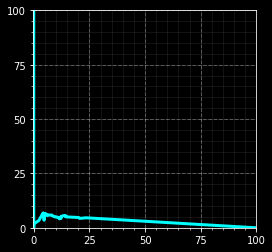

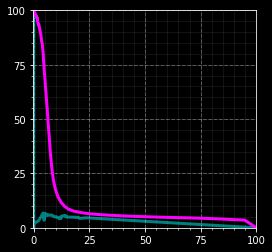

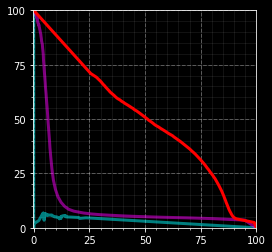

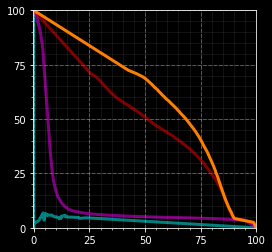

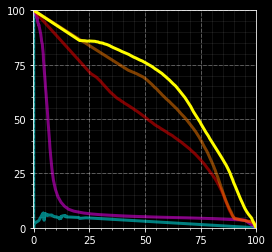

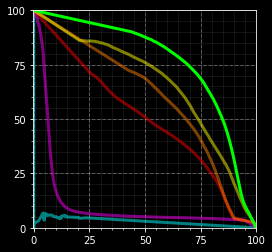

In [99]:
import matplotlib
from matplotlib import pyplot as plt
sorted_precisions = np.sort(interpolated_precisions, axis=1)

model_names = [
    "old-bird",
    "skm",
    "icassp-convnet",
    "icassp-convnet_aug-all-but-noise",
    #"pcen-convnet",
    "pcen-convnet_aug-all",
    "pcen-add-convnet_aug-all-but-noise",
    #"pcen-addntt-convnet_aug-all-but-noise",
    #"pcen-ntt-convnet_aug-all-but-noise",
    #"icassp-convnet_aug-all",
]

model_colors = [
    '#00FFFF',
    "#FE00FF",
    "#FF0000",
    "#FF7F00",
    '#FFFD00',
    '#00FF00',
]
model_legends = []

model_captions = {
    "old-bird": "Old Bird",
    "skm": "Shallow learning",
    "icassp-convnet": "Deep learning",
    "icassp-convnet_aug-all-but-noise": "+ data augmentation",
    "pcen-convnet_aug-all": "+ PCEN",
    "pcen-add-convnet_aug-all-but-noise": "+ adaptive threshold",
}

for n_models in range(1, 1+len(model_names)):
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(4, 4))
    
    for model_id, model_name in enumerate(model_names[:n_models]):
        if model_id == (n_models-1):
            model_alpha = 1.0
        else:
            model_alpha = 0.5
        
        print(model_name)
        eval_mode = "test-CV-F"

        model_color = model_colors[model_id]

        if model_name == "old-bird" or model_name == "skm":
            ax.plot(
                100 * report[model_name][eval_mode]["interpolated_R"],
                100 * report[model_name][eval_mode]["interpolated_P"],
                color = model_color,
                alpha = model_alpha,
                linewidth = 3.0)
        else:
            ax.plot(
                100 * report[model_name][eval_mode]["interpolated_R"],
                100 * np.percentile(
                    report[model_name][eval_mode]["interpolated_P"], 50, axis=1),
                color = model_color,
                alpha = model_alpha,
                linewidth = 3.0)

        model_legend = matplotlib.lines.Line2D([], [], color=model_color, marker='o',
            markersize=8, label=model_captions[model_name])
        model_legends.append(model_legend)


    #plt.legend(handles=model_legends)


    ############################### AXES AND GRID ###################################

    major_ticks = np.linspace(0, 100, 5).astype("int")
    minor_ticks = np.linspace(0, 100, 21).astype("int")
    font_family = "sans"

    ax.set_xlim(-0.3, 100)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticklabels(map(str, major_ticks), family=font_family);
    #ax.set_xlabel("Recall (%)", family=font_family);

    ax.set_ylim(0.0, 100)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.set_yticklabels(map(str, major_ticks), family=font_family);
    #ax.set_ylabel("Precision (%)", family=font_family);

    ax.grid(color='w', linestyle='--', linewidth=1.0, alpha=0.3, which="major")
    ax.grid(color='w', linestyle='-', linewidth=0.5, alpha=0.15, which="minor")
    ax.set_axisbelow(True)
    ax.set_facecolor('k')

    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.yaxis.label.set_color('white')
    ax.xaxis.label.set_color('white')
    ax.tick_params(colors='white', which='major')
    ax.tick_params(colors='white', which='minor')

    fig.set_facecolor('k')

    plt.savefig("dolby2019_precision-recall_" + str(n_models) + ".png", dpi=1000, bbox_inches="tight")
    plt.savefig("dolby2019_precision-recall_" + str(n_models) + ".pdf", bbox_inches="tight")

In [44]:
list(report[model_name])

KeyError: 'icassp-convnet_aug-all-but-noise'

In [5]:
model_names = 

['pcen-convnet_aug-all',
 'pcen-add-convnet_aug-all-but-noise',
 'icassp-convnet_aug-all',
 'pcen-convnet',
 'icassp-convnet']

In [42]:
median_r
#report[model_name]["test-CV-AUPRC"]["CV-F"]

array([ 0.        ,  0.20377635,  0.20377635, ...,  0.96395812,
        0.96404279,  1.        ])

In [14]:
test_mode = "test-CV-AUPRC" 

Ps = ["{:5.2f}%".format(100*np.mean(report[x][test_mode]["CV-P"])) for x in report]
Rs = ["{:5.2f}%".format(100*np.mean(report[x][test_mode]["CV-R"])) for x in report]
F1s = ["{:5.2f}%".format(100*np.mean(report[x][test_mode]["CV-F"])) for x in report]
AUCs = ["{:5.2f}%".format(100*np.mean(report[x][test_mode]["CV-AUPRC"])) for x in report]
metrics = [Ps, Rs, F1s, AUCs]

import pandas as pd
pd.DataFrame([Ps, Rs, F1s, AUCs], columns=model_names,
             index=["Precision", "Recall", "F1 score", "AUPRC"]).T

,Precision,Recall,F1 score,AUPRC
icassp-convnet,43.90%,65.36%,52.27%,52.72%
pcen-convnet,23.04%,16.94%,19.53%,20.72%
pcen-convnet_aug-all,56.46%,63.91%,56.62%,61.31%
pcen-add-convnet_aug-all-but-noise,60.66%,75.64%,67.04%,72.46%
pcen-add-convnet_aug-all,58.20%,46.74%,49.17%,46.86%
icassp-convnet_aug-all,54.84%,69.42%,61.03%,60.59%


In [245]:
report["icassp-convnet"]["CV-AUPRC"]

KeyError: 'CV-AUPRC'

In [72]:


############################# PRINT RESULTS ###################################

print("CONVNET:      P = {:5.2f}%,  R = {:5.2f}%,  F = {:5.2f}%".format(
    100*best_cnn_p, 100*best_cnn_r, 100*best_cnn_f))
ax.text(100*best_cnn_r - 22.0 , 100*best_cnn_p - 9.0,
    "    convnet\n F = {:5.2f}%".format(100*best_cnn_f),
    color="#CB0003", fontsize=11.0, family="serif",
    backgroundcolor="white")


print("ICASSP 2018:  P = {:5.2f}%,  R = {:5.2f}%,  F = {:5.2f}%".format(
    100*best_augcnn_p, 100*best_augcnn_r, 100*best_augcnn_f))
ax.text(100*best_augcnn_r - 3, 100*best_augcnn_p + 5.0,
    " ICASSP 2018 \n  F = {:5.2f}%".format(100*best_augcnn_f),
    color="#990099", fontsize=11.0, family="serif",
    backgroundcolor="white")

print("AUG PCEN:     P = {:5.2f}%,  R = {:5.2f}%,  F = {:5.2f}%".format(
    100*best_pcenall_p, 100*best_pcenall_r, 100*best_pcenall_f))
ax.text(100*best_pcenall_r, 100*best_pcenall_p + 8.0,
    "     PCEN \nF = {:5.2f}%".format(100*best_pcenall_f),
    color="#E67300", fontsize=11.0, family="serif",
    backgroundcolor="white")

CONVNET:      P = 53.72%,  R = 54.82%,  F = 54.27%
ICASSP 2018:  P = 57.62%,  R = 68.78%,  F = 62.71%
AUG PCEN:     P = 64.30%,  R = 58.71%,  F = 61.38%
